In [1]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist

In [17]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [19]:
x_train[0, :5, :5]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [67]:
x_train = x_train.reshape(-1, 28*28)

x_train.shape

(60000, 784)

In [3]:
import os

# change cwd to project root
os.chdir("../")

In [4]:
from src.utils import K_laplace_mat, K_gauss_mat

In [32]:
K = K_gauss_mat(x_train[:50], x_train[:50], 1 / 768)

In [33]:
K

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [29]:
from sklearn.metrics.pairwise import laplacian_kernel, rbf_kernel

In [65]:
Kl = laplacian_kernel(x_train[:50], x_train[:50], gamma=768)
Kg = rbf_kernel(x_train[:50], x_train[:50], gamma=7.68e20)

In [66]:
Kg

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [42]:
from src.etl import generate_test_data

test_data = generate_test_data("xsinx", 100, 0.1)
test_data.shape
X, y = test_data[:, 0].reshape(-1, 1), test_data[:, 1]

In [45]:
kl = K_laplace_mat(X, X, 1 / 768)
kg = K_gauss_mat(X, X, 1 / 768)

In [53]:
laplacian_kernel(X, X, gamma=1 / 768) - kl

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1 / 768, n_components=100)
X_features = rbf_feature.fit_transform(x_train)

In [56]:
X_features.shape

(60000, 100)

In [76]:
from src.etl import generate_test_classification
from sklearn.model_selection import train_test_split

In [192]:
dataset = generate_test_classification(625, 28*28, 2)
X, y = dataset[:, :-1], dataset[:, -1]
print("y classes:", y[:5])
y = np.sign(y - 0.5)
print("y binarized:", y[:5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y classes: [0. 0. 0. 0. 0.]
y binarized: [-1. -1. -1. -1. -1.]


In [193]:
K = K_laplace_mat(X_train, X_train, 0.1)
lam=0.0021544346900318843

In [194]:
alpha_hat = np.linalg.solve(K + lam*np.eye(len(X_train)), y_train)

In [195]:
yhat = np.sign((K @ alpha_hat) + 1e-12)

In [196]:
MSE = np.mean((yhat - y_train)**2)
MSE

0.0

In [197]:
# make confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_train, yhat), accuracy_score(y_train, yhat)

(array([[246,   0],
        [  0, 254]]), 1.0)

In [202]:
yhat_test = np.sign((K_laplace_mat(X_test, X_train, lam) @ alpha_hat) + 1e-12)

In [203]:
np.mean((yhat_test - y_test)**2)

0.096

In [204]:
confusion_matrix(y_test, yhat_test), accuracy_score(y_test, yhat_test)

(array([[64,  3],
        [ 0, 58]]), 0.976)

In [205]:
yhat_test

array([ 1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.,
        1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,
        1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,
       -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
       -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
       -1.,  1.,  1., -1., -1.,  1., -1., -1.])

In [160]:
import matplotlib.pyplot as plt

In [163]:
def get_mse(lam):
    yhat_test = np.sign((K_laplace_mat(X_test, X_train, lam) @ alpha_hat) + 1e-12)
    return np.mean((yhat_test - y_test)**2)

In [165]:
from tqdm import tqdm_notebook as tqdm

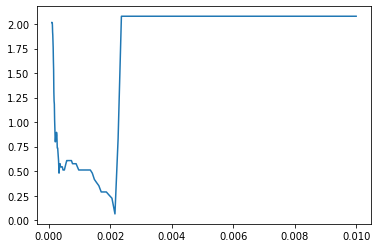

In [171]:
lams = np.logspace(-4, -2, 100)
mses = [get_mse(lam) for lam in tqdm(lams)]

plt.plot(lams, mses)

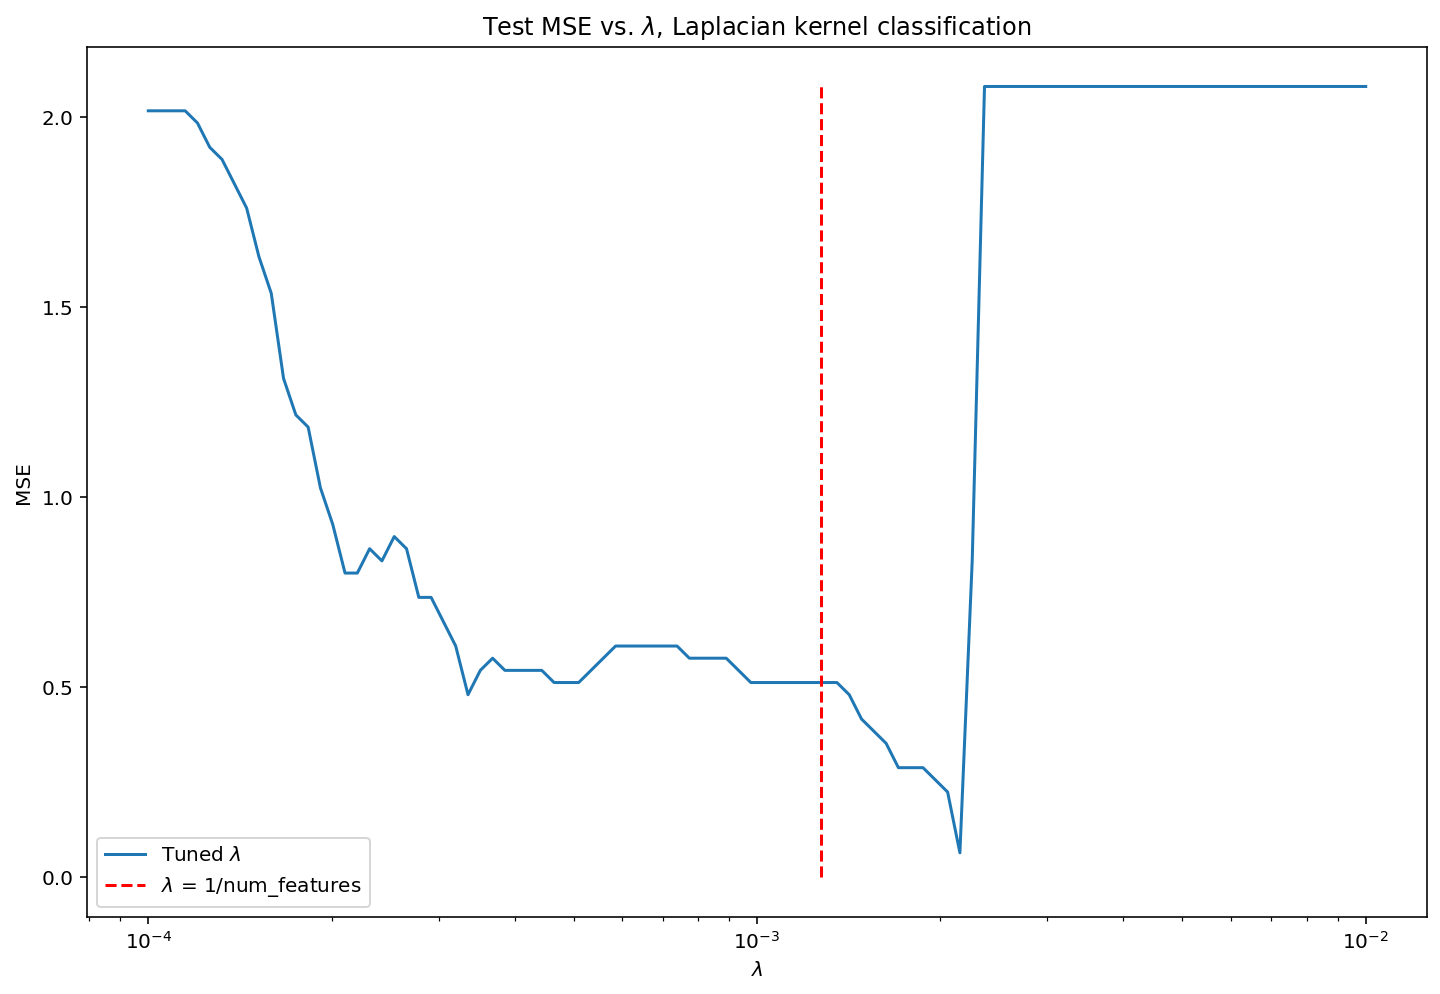

In [190]:
# make a plot of lams and mses with axes labeled and a logarithmic x axis
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 8))
plt.plot(lams, mses, label="Tuned $\lambda$")
plt.plot([1/(28*28), 1/(28*28)], [0, np.max(mses)], 'r--', label="$\lambda$ = 1/num_features")
plt.xscale("log")
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.title("Test MSE vs. $\lambda$, Laplacian kernel classification")
plt.legend()

In [183]:
1/(28*28)

0.0012755102040816326

In [191]:
print("Lowest MSE lambda:", lams[np.argmin(mses)])

Lowest MSE lambda: 0.0021544346900318843
